In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192

sns.set_style()

## Estimate species spectra homogenity

In [43]:
# load spectra dataset
path_to_data = "../../1data_derivation/dataset/MutSpecVertebrates192.csv.gz"
mutspec = pd.read_csv(path_to_data)
mutspec = mutspec[mutspec.Gene == 'Cytb']
print("#species", mutspec.Species.nunique())
print(mutspec.shape)
mutspec.head()

#species 1697
(325824, 7)


Gene     Class           Species      Mut  Observed  Expected  MutSpec
39552  Cytb  Mammalia  Tarsius_dentatus  A[A>C]A       NaN      0.00      0.0
39553  Cytb  Mammalia  Tarsius_dentatus  A[A>C]C       NaN      0.00      0.0
39554  Cytb  Mammalia  Tarsius_dentatus  A[A>C]G       NaN      0.00      0.0
39555  Cytb  Mammalia  Tarsius_dentatus  A[A>C]T       NaN      0.00      0.0
39556  Cytb  Mammalia  Tarsius_dentatus  C[A>C]A       NaN     11.95      0.0

In [59]:
# Drop species with low number of observed mutations!
# Each species have too low number of mutations, we want to use most qualitative data
sp_count = mutspec.groupby("Species").Observed.sum()

MIN_MUT_NUM = 50
mutspec = mutspec[mutspec.Species.isin(sp_count[sp_count >= MIN_MUT_NUM].index)]
print("#species", mutspec.Species.nunique())
mutspec.shape[0]

#species 757


145344

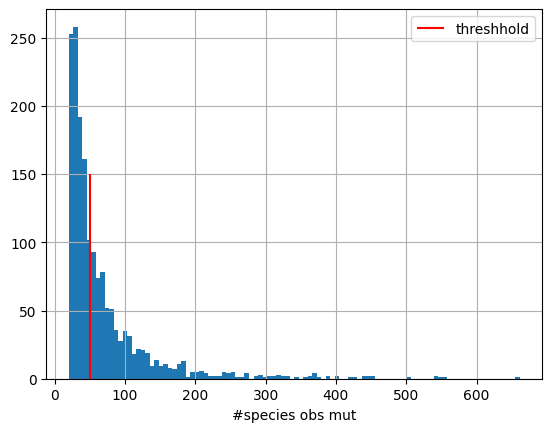

In [45]:
sp_count.hist(bins=100)
plt.xlabel("#species obs mut");
plt.vlines([MIN_MUT_NUM], 0, 150, 'r', label='threshhold')
plt.legend();

In [46]:
# reformat table to wide format
sp2mut = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
sp2mut = sp2mut[possible_sbs192]
print(sp2mut.shape)
sp2mut.head().round(2)

(757, 192)


Mut                                   A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  \
Class       Species                                                        
Actinopteri Acanthopagrus_latus           0.0      0.0      0.0      0.0   
            Acheilognathus_tabira         0.0      0.0      0.0      0.0   
            Achondrostoma_arcasii         0.0      0.0      0.0      0.0   
            Achondrostoma_numantinum      0.0      0.0      0.0      0.0   
            Acipenser_stellatus           0.0      0.0      0.0      0.0   

Mut                                   C[A>C]A  C[A>C]C  C[A>C]G  C[A>C]T  \
Class       Species                                                        
Actinopteri Acanthopagrus_latus           0.0      0.0      0.0      0.0   
            Acheilognathus_tabira         0.0      0.0      0.0      0.0   
            Achondrostoma_arcasii         0.0      0.0      0.0      0.0   
            Achondrostoma_numantinum      0.0      0.0      0.0      0.0   
            Acipenser_stellatus           0.0      0.0      0.0      0.0   

Mut                                   G[A>C]A  G[A>C]C  ...  C[T>G]G  C[T>G]T  \
Class       Species                                     ...                     
Actinopteri Acanthopagrus_latus           0.0      0.0  ...      0.0     0.00   
            Acheilognathus_tabira         0.0      0.0  ...      0.0     0.00   
            Achondrostoma_arcasii         0.0      0.0  ...      0.0     0.00   
            Achondrostoma_numantinum      0.0      0.0  ...      0.0     0.04   
            Acipenser_stellatus           0.0      0.0  ...      0.0     0.08   

Mut                                   G[T>G]A  G[T>G]C  G[T>G]G  G[T>G]T  \
Class       Species                                                        
Actinopteri Acanthopagrus_latus           0.0      0.0      0.0      0.0   
            Acheilognathus_tabira         0.0      0.0      0.0      0.0   
            Achondrostoma_arcasii         0.0      0.0      0.0      0.0   
            Achondrostoma_numantinum      0.0      0.0      0.0      0.0   
            Acipenser_stellatus           0.0      0.0      0.0      0.0   

Mut                                   T[T>G]A  T[T>G]C  T[T>G]G  T[T>G]T  
Class       Species                                                       
Actinopteri Acanthopagrus_latus           0.0      0.0      0.0      0.0  
            Acheilognathus_tabira         0.0      0.0      0.0      0.0  
            Achondrostoma_arcasii         0.0      0.0      0.0      0.0  
            Achondrostoma_numantinum      0.0      0.0      0.0      0.0  
            Acipenser_stellatus           0.0      0.0      0.0      0.0  

[5 rows x 192 columns]

In [47]:
# prepare Ts list
transitions = [x for x in possible_sbs192 if x[2:5] in {"C>T", "T>C", "A>G", "G>A"}]
len(transitions)

64

In [48]:
# Use only transitions due to low transversions abundance

# df = sp2mut
df = sp2mut[transitions]

## Pairwise species-specific comparison (192-comp)

visualization refs:
- [link](https://seaborn.pydata.org/generated/seaborn.clustermap.html)
- [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
- [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
- [link](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot)

In [49]:
# sort species according to similarity inside classes 
data = []
cls_order = ['Aves', 'Lepidosauria', 'Amphibia', 'Actinopteri', 'Mammalia']
for _cls in cls_order:
    print(_cls)
    cls_sp = sp2mut.loc[_cls]
    cls_sp_sim = pd.DataFrame(1 - squareform(pdist(cls_sp, "cosine")), index=cls_sp.index, columns=cls_sp.index)
    dn = dendrogram(linkage(cls_sp_sim), no_plot=True)
    dn["leaves"]
    data.append(cls_sp.iloc[dn["leaves"]].assign(Class=_cls).reset_index().set_index(["Class", "Species"]))

sp2mut_sorted = pd.concat(data)

assert (sp2mut_sorted.sort_index() == sp2mut.sort_index()).all().all()

Aves
Lepidosauria
Amphibia
Actinopteri
Mammalia


In [51]:
# compute pairwise cossim of species spectra
sp_sim = pd.DataFrame(1 - squareform(pdist(sp2mut_sorted, "cosine")), 
                      index=sp2mut_sorted.index, columns=sp2mut_sorted.index)
sp_sim.head()

Class                                 Aves                \
Species                          Pica_pica Gallus_gallus   
Class Species                                              
Aves  Pica_pica                   1.000000      0.106595   
      Gallus_gallus               0.106595      1.000000   
      Dendrocincla_fuliginosa     0.579541      0.037628   
      Corvus_macrorhynchos        0.075136      0.093135   
      Phylloscopus_poliocephalus  0.482943      0.067772   

Class                                                                          \
Species                          Dendrocincla_fuliginosa Corvus_macrorhynchos   
Class Species                                                                   
Aves  Pica_pica                                 0.579541             0.075136   
      Gallus_gallus                             0.037628             0.093135   
      Dendrocincla_fuliginosa                   1.000000             0.279071   
      Corvus_macrorhynchos                      0.279071             1.000000   
      Phylloscopus_poliocephalus                0.548752             0.324308   

Class                                                                         \
Species                          Phylloscopus_poliocephalus Alectoris_chukar   
Class Species                                                                  
Aves  Pica_pica                                    0.482943         0.024220   
      Gallus_gallus                                0.067772         0.017422   
      Dendrocincla_fuliginosa                      0.548752         0.685587   
      Corvus_macrorhynchos                         0.324308         0.357816   
      Phylloscopus_poliocephalus                   1.000000         0.518959   

Class                                                               \
Species                          Garrulax_chinensis Xenops_minutus   
Class Species                                                        
Aves  Pica_pica                            0.103608       0.013128   
      Gallus_gallus                        0.020791       0.034462   
      Dendrocincla_fuliginosa              0.551520       0.395827   
      Corvus_macrorhynchos                 0.447739       0.487945   
      Phylloscopus_poliocephalus           0.653186       0.639429   

Class                                                                      \
Species                          Cinclosoma_clarum Glyphorynchus_spirurus   
Class Species                                                               
Aves  Pica_pica                           0.050185               0.083516   
      Gallus_gallus                       0.042925               0.181786   
      Dendrocincla_fuliginosa             0.405413               0.504006   
      Corvus_macrorhynchos                0.219292               0.380231   
      Phylloscopus_poliocephalus          0.227198               0.399650   

Class                             ...      Mammalia                        \
Species                           ... Rusa_unicolor Stenella_longirostris   
Class Species                     ...                                       
Aves  Pica_pica                   ...      0.064732              0.130857   
      Gallus_gallus               ...      0.021951              0.047833   
      Dendrocincla_fuliginosa     ...      0.345813              0.325661   
      Corvus_macrorhynchos        ...      0.113743              0.061324   
      Phylloscopus_poliocephalus  ...      0.104535              0.090197   

Class                                                                  \
Species                          Niviventer_fulvescens Tamias_amoenus   
Class Species                                                           
Aves  Pica_pica                               0.084517       0.078640   
      Gallus_gallus                           0.039530       0.029153   
      Dendrocincla_fuliginosa                 0.268837       0.318006

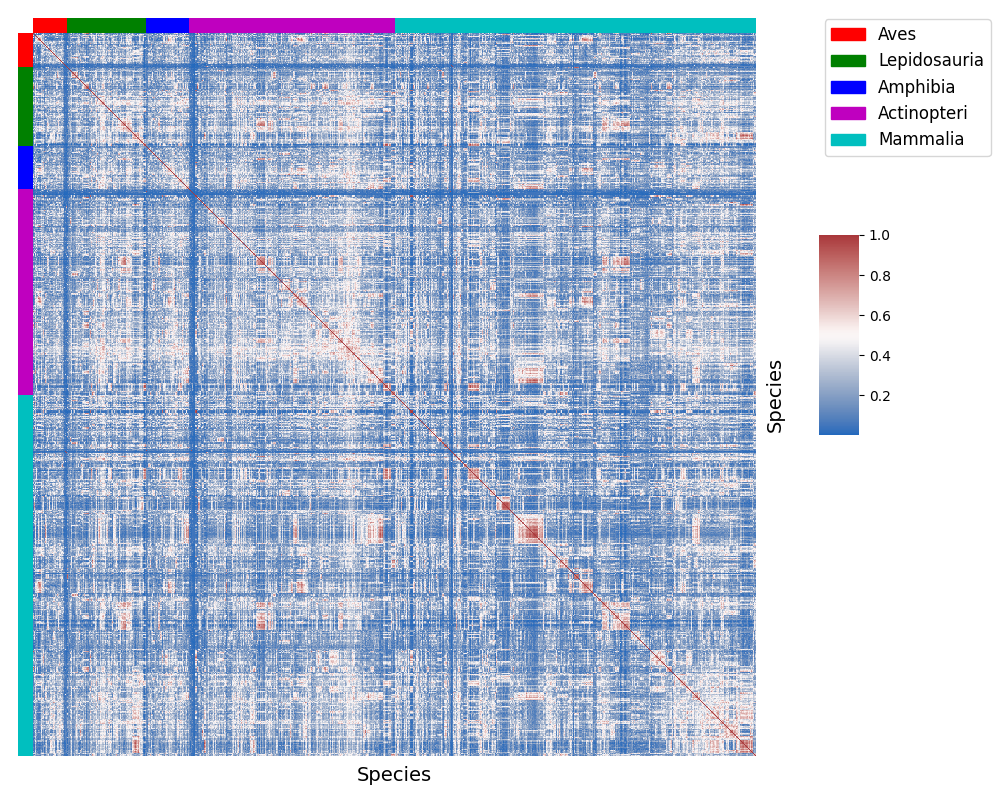

In [52]:
# plot heatmap
cls_colors = "rgbmc"

g = sns.clustermap(
    sp_sim, 
    cmap="vlag",
    metric="cosine",
    row_cluster=False,
    col_cluster=False,
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    cbar_pos=(1.03, 0.45, 0.05, 0.25),
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 8),
    dendrogram_ratio=0.01,
    colors_ratio=0.02,
)

g.ax_heatmap.set_xlabel("Species", fontsize=14)
g.ax_heatmap.set_ylabel("Species", fontsize=14)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(cls_colors, cls_order)]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(4.5, 2.12))


plt.savefig("./species_pairwise_similarity.png", bbox_inches="tight")
plt.show()

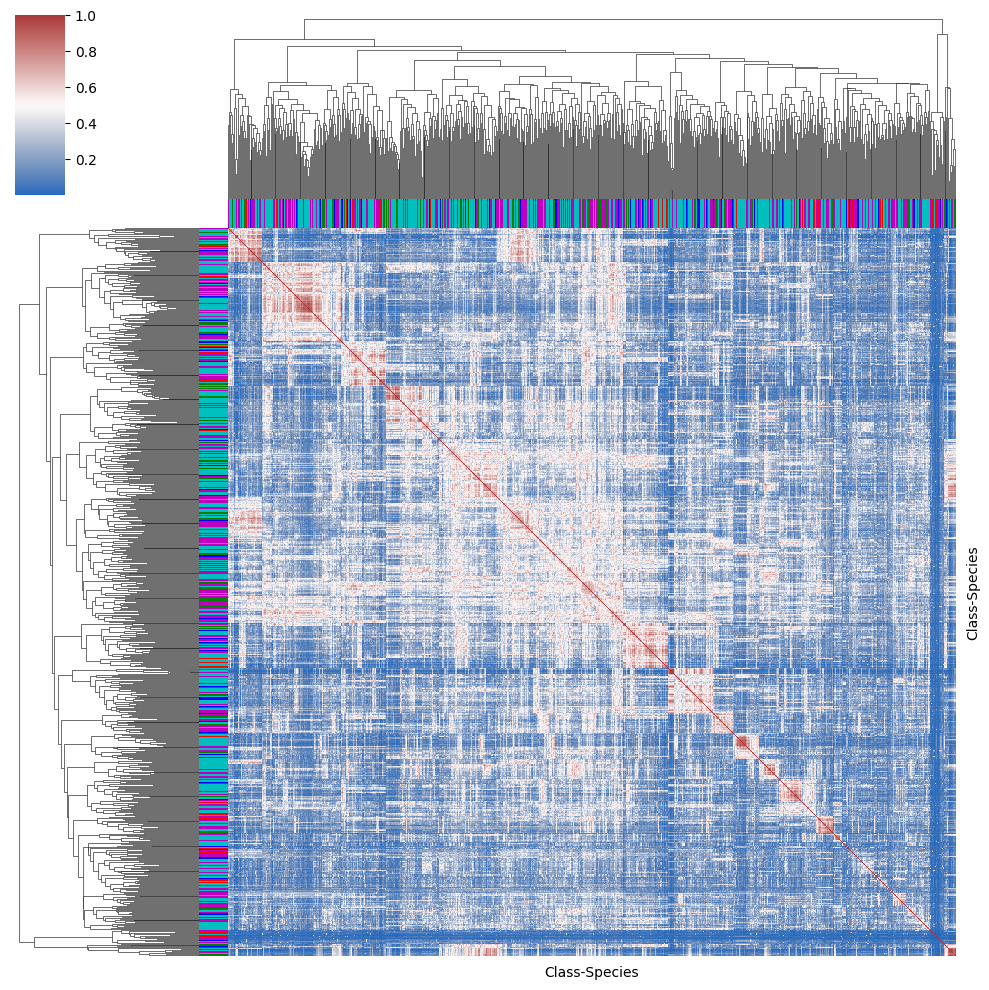

In [54]:
# plot clustermap without custom class-specific sorting
# we see some clusters but they are not class-specific
cls_colors = "rgbmc"

sns.clustermap(
    sp_sim, cmap="vlag", 
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    xticklabels=False,
    yticklabels=False,
);

## Pairwise species-specific comparison (12-comp)

In [55]:
# collapse 192-component spectra to 12-component ones
from pymutspec.annotation.spectra import collapse_sbs192
sp2mut_sorted12 = collapse_sbs192(sp2mut_sorted, 12)
sp2mut_sorted12

Mut                                       A>C       A>G       A>T       C>A  \
Class    Species                                                              
Aves     Pica_pica                   0.003056  0.045705  0.000000  0.002153   
         Gallus_gallus               0.000000  0.032388  0.005014  0.015030   
         Dendrocincla_fuliginosa     0.000000  0.048138  0.012615  0.006684   
         Corvus_macrorhynchos        0.000000  0.088751  0.000000  0.032681   
         Phylloscopus_poliocephalus  0.000000  0.046823  0.000000  0.039917   
...                                       ...       ...       ...       ...   
Mammalia Oxymycterus_quaestor        0.002941  0.098223  0.000000  0.007793   
         Reithrodontomys_megalotis   0.000000  0.075347  0.005728  0.073627   
         Lepus_timidus               0.013871  0.090408  0.026996  0.025368   
         Saccostomus_campestris      0.000000  0.107718  0.006100  0.004253   
         Thylamys_pusillus           0.000000  0.040537  0.042820  0.000000   

Mut                                       C>G       C>T       G>A       G>C  \
Class    Species                                                              
Aves     Pica_pica                   0.001077  0.045788  0.814800  0.000000   
         Gallus_gallus               0.006305  0.023320  0.812111  0.012568   
         Dendrocincla_fuliginosa     0.000000  0.109198  0.658413  0.000000   
         Corvus_macrorhynchos        0.000000  0.233652  0.372837  0.000000   
         Phylloscopus_poliocephalus  0.000000  0.099017  0.577489  0.000000   
...                                       ...       ...       ...       ...   
Mammalia Oxymycterus_quaestor        0.000000  0.050924  0.540084  0.000000   
         Reithrodontomys_megalotis   0.015360  0.299982  0.317192  0.000000   
         Lepus_timidus               0.000000  0.228068  0.356601  0.000000   
         Saccostomus_campestris      0.000000  0.058628  0.597127  0.056179   
         Thylamys_pusillus           0.000000  0.079931  0.596227  0.000000   

Mut                                       G>T       T>A       T>C       T>G  
Class    Species                                                             
Aves     Pica_pica                   0.000000  0.006788  0.072886  0.007747  
         Gallus_gallus               0.000000  0.000000  0.093263  0.000000  
         Dendrocincla_fuliginosa     0.016925  0.000000  0.148026  0.000000  
         Corvus_macrorhynchos        0.067753  0.000000  0.204327  0.000000  
         Phylloscopus_poliocephalus  0.000000  0.000000  0.236753  0.000000  
...                                       ...       ...       ...       ...  
Mammalia Oxymycterus_quaestor        0.000000  0.000000  0.300035  0.000000  
         Reithrodontomys_megalotis   0.000000  0.011358  0.196292  0.005115  
         Lepus_timidus               0.000000  0.015419  0.243270  0.000000  
         Saccostomus_campestris      0.000000  0.000000  0.159375  0.010621  
         Thylamys_pusillus           0.067031  0.032163  0.141290  0.000000  

[757 rows x 12 columns]

In [56]:
sp_sim12 = pd.DataFrame(1 - squareform(pdist(sp2mut_sorted12, "cosine")), 
                      index=sp2mut_sorted12.index, columns=sp2mut_sorted12.index)
sp_sim12.head()

Class                                 Aves                \
Species                          Pica_pica Gallus_gallus   
Class Species                                              
Aves  Pica_pica                   1.000000      0.998815   
      Gallus_gallus               0.998815      1.000000   
      Dendrocincla_fuliginosa     0.985352      0.984714   
      Corvus_macrorhynchos        0.814570      0.809568   
      Phylloscopus_poliocephalus  0.949103      0.953207   

Class                                                                          \
Species                          Dendrocincla_fuliginosa Corvus_macrorhynchos   
Class Species                                                                   
Aves  Pica_pica                                 0.985352             0.814570   
      Gallus_gallus                             0.984714             0.809568   
      Dendrocincla_fuliginosa                   1.000000             0.897114   
      Corvus_macrorhynchos                      0.897114             1.000000   
      Phylloscopus_poliocephalus                0.984494             0.922728   

Class                                                                         \
Species                          Phylloscopus_poliocephalus Alectoris_chukar   
Class Species                                                                  
Aves  Pica_pica                                    0.949103         0.997574   
      Gallus_gallus                                0.953207         0.997078   
      Dendrocincla_fuliginosa                      0.984494         0.972513   
      Corvus_macrorhynchos                         0.922728         0.775772   
      Phylloscopus_poliocephalus                   1.000000         0.929063   

Class                                                               \
Species                          Garrulax_chinensis Xenops_minutus   
Class Species                                                        
Aves  Pica_pica                            0.986437       0.771688   
      Gallus_gallus                        0.991119       0.774856   
      Dendrocincla_fuliginosa              0.988111       0.864449   
      Corvus_macrorhynchos                 0.840167       0.969921   
      Phylloscopus_poliocephalus           0.975665       0.919006   

Class                                                                      \
Species                          Cinclosoma_clarum Glyphorynchus_spirurus   
Class Species                                                               
Aves  Pica_pica                           0.699092               0.736772   
      Gallus_gallus                       0.711643               0.745275   
      Dendrocincla_fuliginosa             0.794772               0.829053   
      Corvus_macrorhynchos                0.881797               0.919792   
      Phylloscopus_poliocephalus          0.882268               0.907627   

Class                             ...      Mammalia                        \
Species                           ... Rusa_unicolor Stenella_longirostris   
Class Species                     ...                                       
Aves  Pica_pica                   ...      0.929405              0.904573   
      Gallus_gallus               ...      0.930612              0.909716   
      Dendrocincla_fuliginosa     ...      0.976118              0.959007   
      Corvus_macrorhynchos        ...      0.949025              0.938998   
      Phylloscopus_poliocephalus  ...      0.994531              0.989242   

Class                                                                  \
Species                          Niviventer_fulvescens Tamias_amoenus   
Class Species                                                           
Aves  Pica_pica                               0.879007       0.962304   
      Gallus_gallus                           0.886103       0.956381   
      Dendrocincla_fuliginosa                 0.903712       0.987464

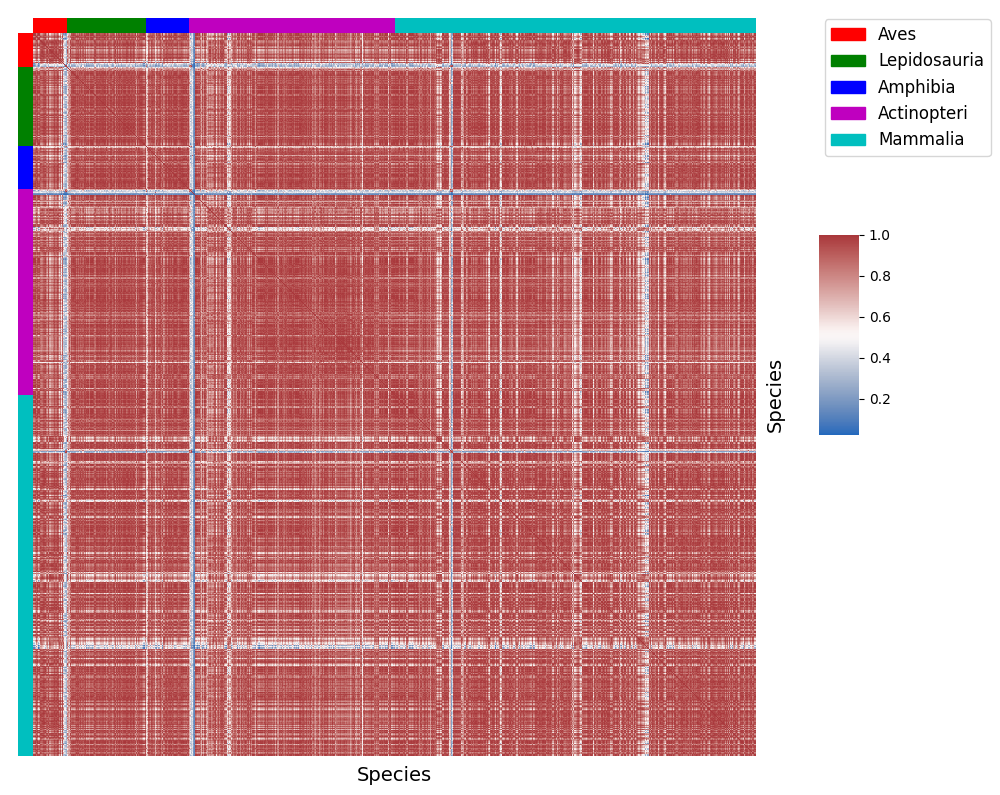

In [57]:
# here on 12-component spectra we again don't see class-clustering:
# every species spectrum is similar to each other 

cls_colors = "rgbmc"

g = sns.clustermap(
    sp_sim12, 
    cmap="vlag",
    metric="cosine",
    row_cluster=False,
    col_cluster=False,
    row_colors=sp_sim12.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim12.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    cbar_pos=(1.03, 0.45, 0.05, 0.25),
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 8),
    dendrogram_ratio=0.01,
    colors_ratio=0.02,
)

g.ax_heatmap.set_xlabel("Species", fontsize=14)
g.ax_heatmap.set_ylabel("Species", fontsize=14)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(cls_colors, cls_order)]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(4.5, 2.12))


plt.savefig("./species_pairwise_similarity12.png", bbox_inches="tight")
plt.show()

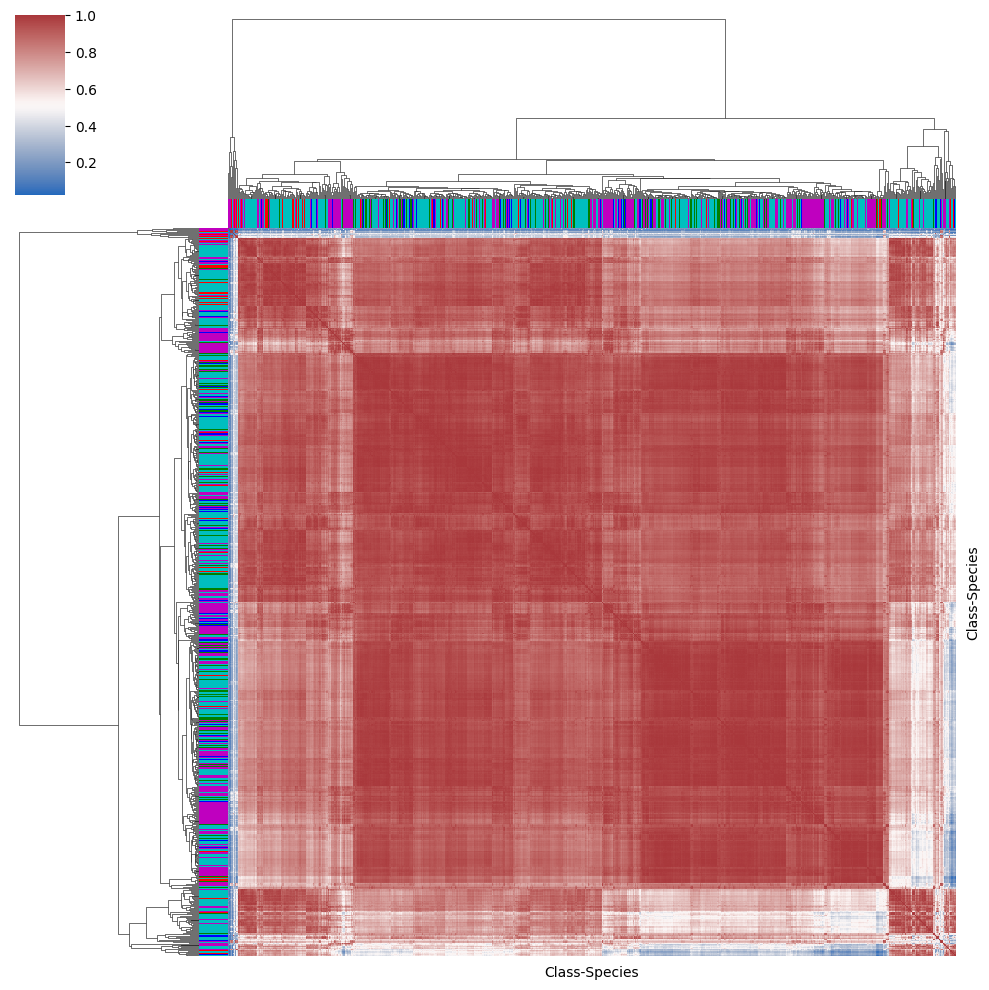

In [58]:
cls_colors = "rgbmc"

sns.clustermap(
    sp_sim12, cmap="vlag", 
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    xticklabels=False,
    yticklabels=False,
);

Cannot see class similarities again